# Convolutional Neural Network

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sklearn.preprocessing
import sklearn.metrics
import tensorflow as tf
import tensorflow.contrib.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import itertools
import spectraldl.plot as plot

Using TensorFlow backend.


In [3]:
tf.__version__

'1.1.0-rc1'

In [4]:
N_CLASSES = 3

In [5]:
with h5py.File('data/data.hdf5') as f:
    X_tr = f['X_tr'][...]
    y_tr = f['y_tr'][...]
    X_val = f['X_val'][...]
    y_val = f['y_val'][...]

In [6]:
X_tr = sklearn.preprocessing.scale(X_tr, axis=1)
X_val = sklearn.preprocessing.scale(X_val, axis=1)

In [7]:
y_oh_tr = keras.utils.to_categorical(y_tr, num_classes=N_CLASSES)
y_oh_val = keras.utils.to_categorical(y_val, num_classes=N_CLASSES)

In [8]:
# create a model
model = Sequential([
    Dense(units=128, activation='relu', input_dim=X_tr.shape[-1]),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=N_CLASSES, activation='softmax'),
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adagrad',
    metrics=['accuracy'],
)

In [9]:
# fit the model
hist = model.fit(
    X_tr, y_oh_tr,
    epochs=1000, batch_size=256, verbose=2,
    validation_data=(X_val, y_oh_val)
)

Train on 9314 samples, validate on 2329 samples
Epoch 1/1000
1s - loss: 0.6427 - acc: 0.7989 - val_loss: 0.2252 - val_acc: 0.9214
Epoch 2/1000
0s - loss: 0.3053 - acc: 0.8930 - val_loss: 0.1831 - val_acc: 0.9498
Epoch 3/1000
0s - loss: 0.2421 - acc: 0.9181 - val_loss: 0.1541 - val_acc: 0.9519
Epoch 4/1000
0s - loss: 0.2110 - acc: 0.9321 - val_loss: 0.1661 - val_acc: 0.9480
Epoch 5/1000
0s - loss: 0.1979 - acc: 0.9407 - val_loss: 0.1294 - val_acc: 0.9575
Epoch 6/1000
0s - loss: 0.1761 - acc: 0.9438 - val_loss: 0.1203 - val_acc: 0.9631
Epoch 7/1000
0s - loss: 0.1696 - acc: 0.9470 - val_loss: 0.1283 - val_acc: 0.9605
Epoch 8/1000
0s - loss: 0.1652 - acc: 0.9488 - val_loss: 0.1198 - val_acc: 0.9614
Epoch 9/1000
0s - loss: 0.1527 - acc: 0.9503 - val_loss: 0.1115 - val_acc: 0.9631
Epoch 10/1000
0s - loss: 0.1438 - acc: 0.9533 - val_loss: 0.1175 - val_acc: 0.9631
Epoch 11/1000
0s - loss: 0.1475 - acc: 0.9557 - val_loss: 0.1296 - val_acc: 0.9605
Epoch 12/1000
0s - loss: 0.1436 - acc: 0.9579 - 

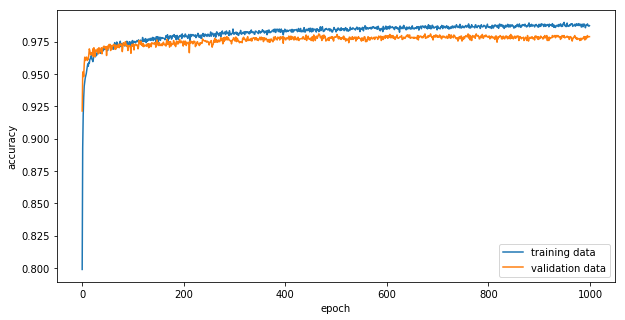

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist.epoch, hist.history['acc'], label='training data')
ax.plot(hist.epoch, hist.history['val_acc'], label='validation data')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()

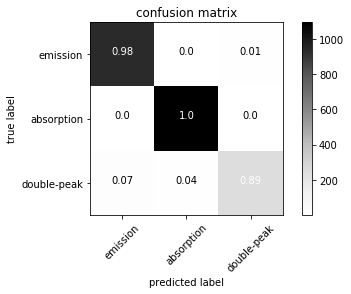

In [13]:
y_out = model.predict_classes(X_val, verbose=0)
cm = sklearn.metrics.confusion_matrix(y_val, y_out)
plot.plot_confusion_matrix(cm, ['emission', 'absorption', 'double-peak'], normalize=True)

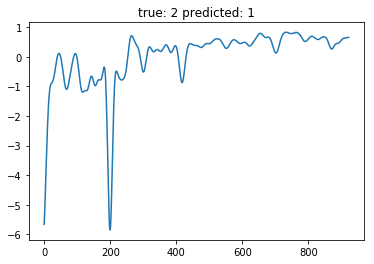

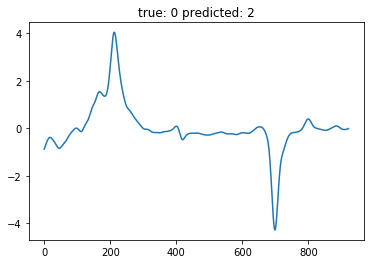

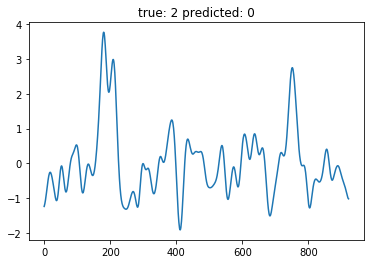

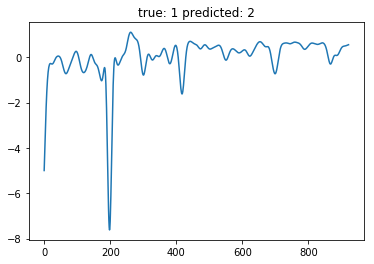

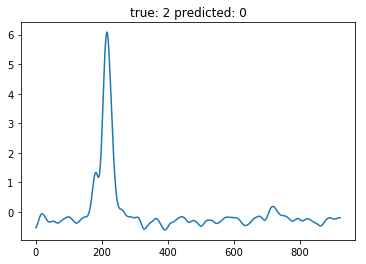

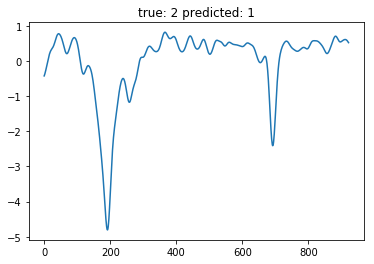

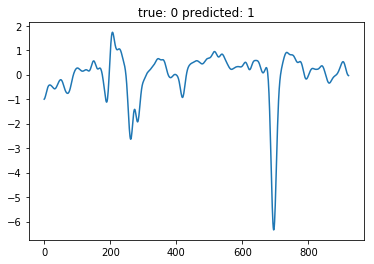

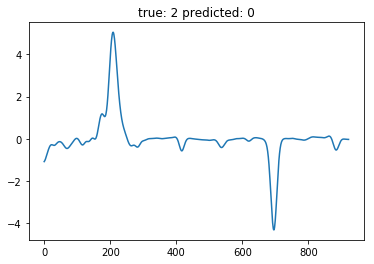

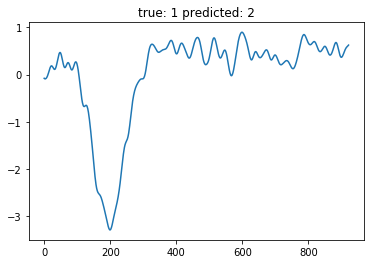

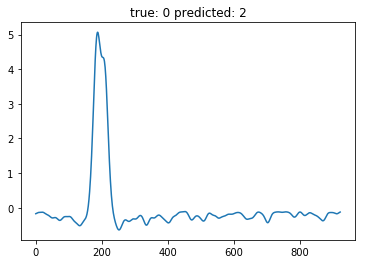

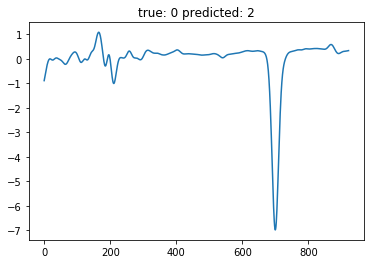

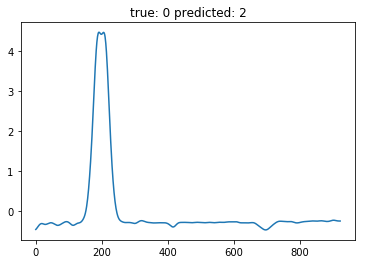

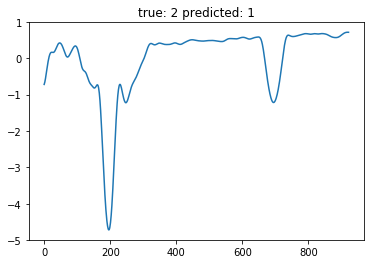

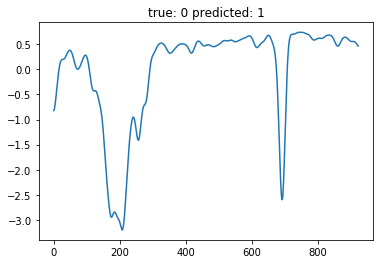

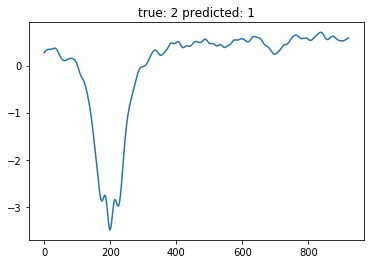

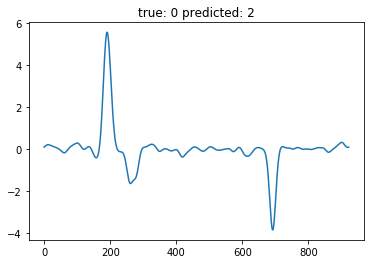

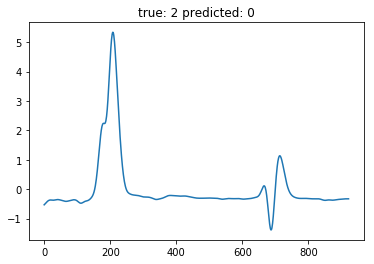

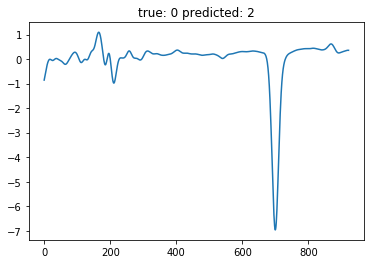

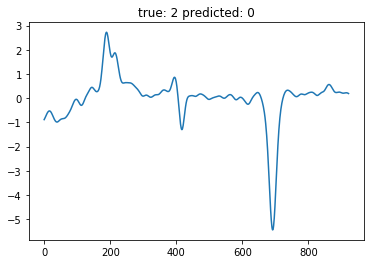

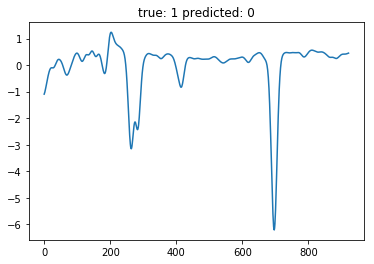

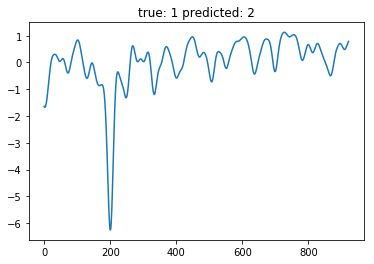

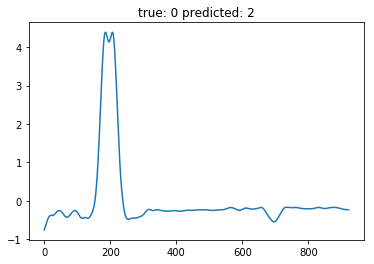

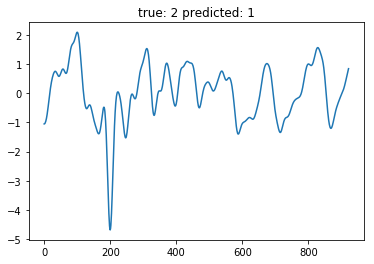

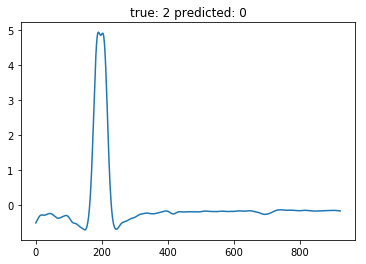

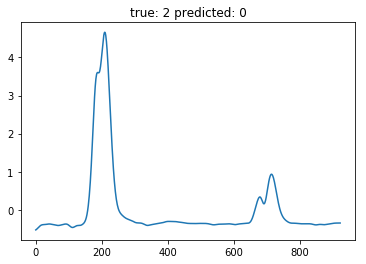

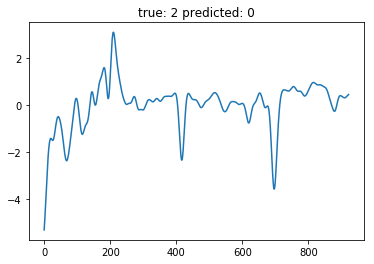

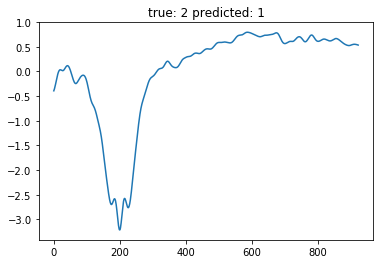

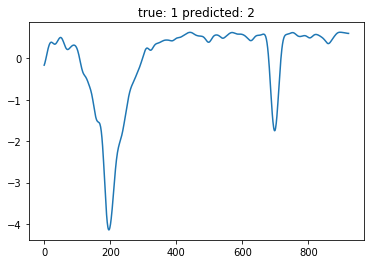

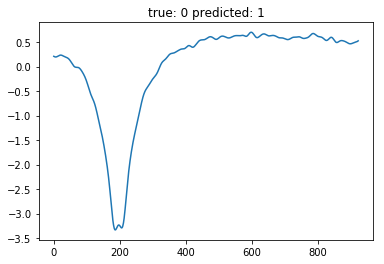

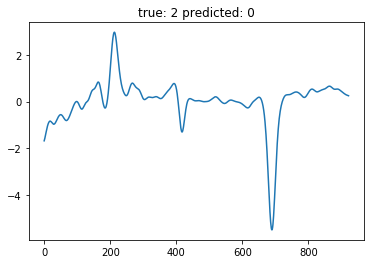

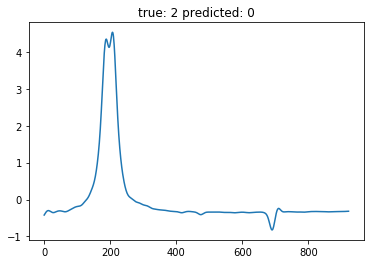

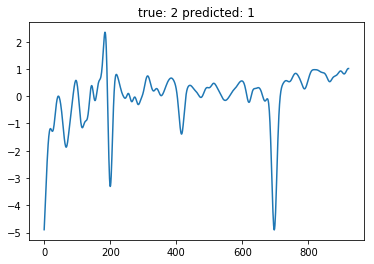

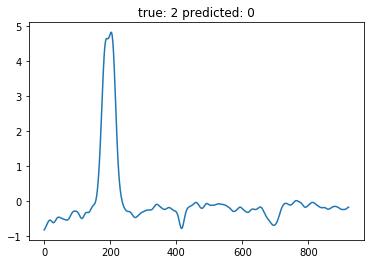

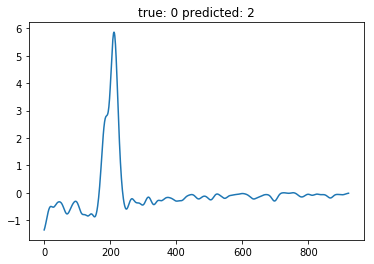

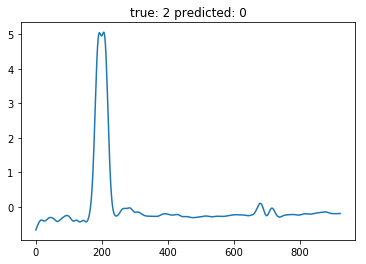

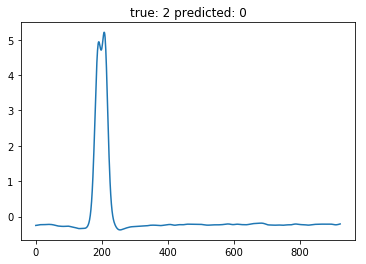

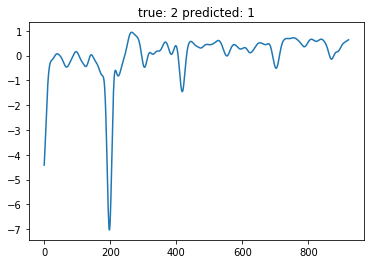

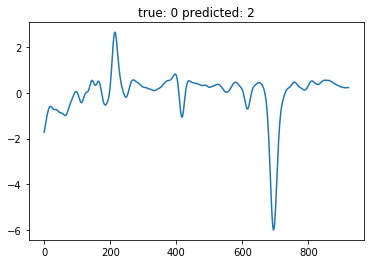

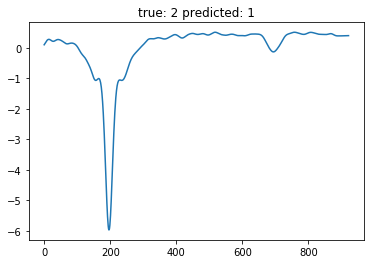

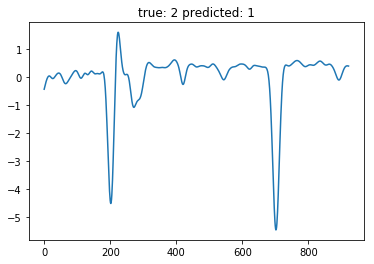

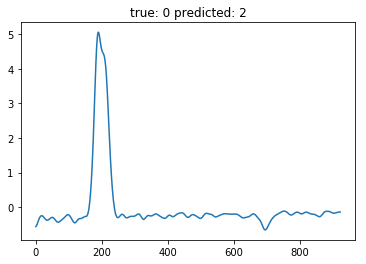

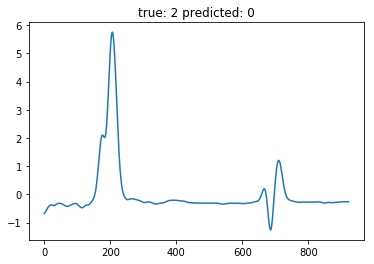

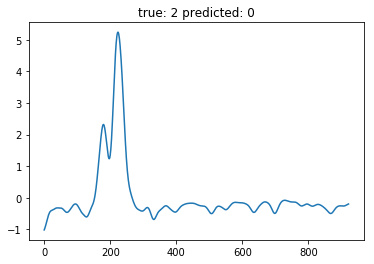

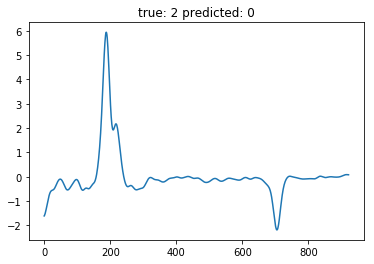

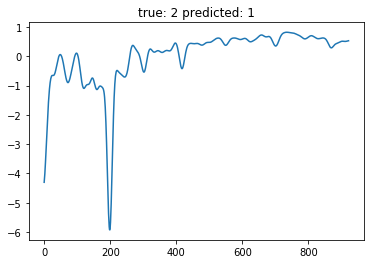

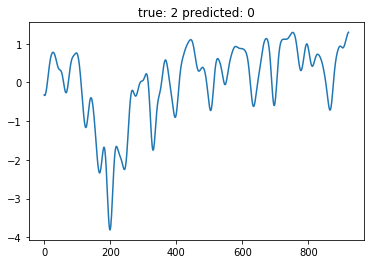

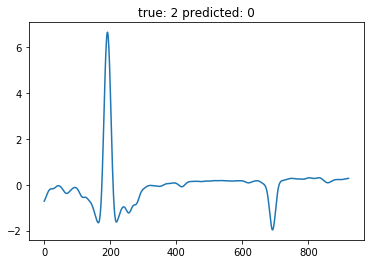

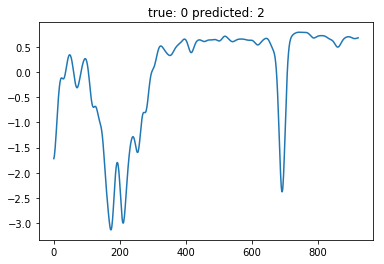

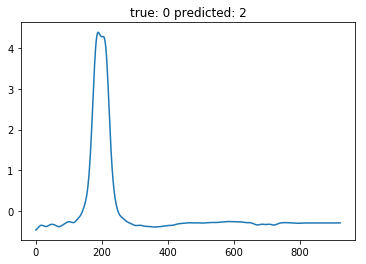

In [12]:
idx = np.not_equal(y_val, y_out)
for x, true, pred in zip(X_val[idx], y_val[idx], y_out[idx]):
    plt.plot(x)
    plt.title('true: {} predicted: {}'.format(true, pred))
    plt.show()